In [1]:
# Imports
import torch
import time
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader , random_split
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define hyperparameters
Batch_size = 256
Random_seed = 40
Num_epochs = 50

# Set random seed for reproducibility
torch.manual_seed(Random_seed)
generator1 = torch.Generator().manual_seed(Random_seed)

# Gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Tranformations
train_transformation = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.5, 0.5, 0.5]), std = [0.5, 0.5, 0.5])])

test_transformation = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.5, 0.5, 0.5]), std = [0.5, 0.5, 0.5])])

In [4]:
# Use Image Folder to load datasets
train_dataset = datasets.ImageFolder(root='/kaggle/input/cifar10-pngs-in-folders/cifar10/train', 
                                     transform= train_transformation)

test_dataset = datasets.ImageFolder(root='/kaggle/input/cifar10-pngs-in-folders/cifar10/test', 
                                     transform= test_transformation)

# Get Validation set
validation_size= int(0.1* (len(train_dataset)))
train_size = int(len(train_dataset) - validation_size)
train_dataset, valid_dataset = random_split(train_dataset, [train_size, validation_size], generator=generator1)

# Set validation tranformation to same as test tranformation
valid_dataset.transform=test_transformation

In [5]:
# Load datasets into Dataloader for iterating over the datasets
train_loader = DataLoader(train_dataset, batch_size = Batch_size, shuffle=True, drop_last=True,)
valid_loader = DataLoader(valid_dataset, batch_size = Batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = Batch_size, shuffle=False)


In [6]:
# Check trainloader
for features, labels in train_loader:
    print(f'Image Dimensions {features.shape}')
    print(f'Labels Dimensions {labels.shape}')
    print(f'Class labels of 10 examples - {labels[:10]}')
    break


Image Dimensions torch.Size([256, 3, 64, 64])
Labels Dimensions torch.Size([256])
Class labels of 10 examples - tensor([1, 5, 4, 7, 8, 4, 7, 0, 9, 1])


In [7]:
# Alexnet model
class Alexnet(torch.nn.Module):
  def __init__(self, num_classes):
      super().__init__()
      self.features = torch.nn.Sequential(
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
      self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
      self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.6),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.6),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

  def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = x.view(x.size(0), 256 * 6 * 6)
      logits = self.classifier(x)
      return logits

In [8]:
# Initialise model
model= Alexnet(num_classes = 10)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [9]:
# Define accuracy function
def compute_accuracy(model, data_loader):
    correct, num_examples = 0, 0
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        predicted_labels = torch.argmax(logits, dim=1)
        correct += (predicted_labels == labels).sum().item()
        num_examples += labels.size(0)
    return (correct / num_examples) * 100


In [10]:
# Training the Model
mini_batch_loss, train_acc_list, valid_acc_list = [], [], []

start_time = time.time()
for epoch in range(Num_epochs):
    model.train()  # set model in train mode
    for batch_idx, (features, label) in enumerate(train_loader):

        features = features.to(device)
        label = label.to(device)

        # Compute logits
        logits = model(features)
        # Compute loss
        loss = F.cross_entropy(logits, label)
        optimizer.zero_grad()
        # Backprops
        loss.backward()
        # Update gradient
        optimizer.step()

        # Logging
        mini_batch_loss.append(loss.item())
        if batch_idx % 100 ==0 :
           print(f'Epoch : {epoch + 1:03d}/{Num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader)} | Loss : {loss.item():.3f}')

    model.eval()
    with torch.no_grad():  # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        valid_acc = compute_accuracy(model, valid_loader)
        print(f'Epoch : {epoch+1:03d}/{Num_epochs:03d} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')
        print(f'Time elapsed: {(((time.time() - start_time)/60)):.2f} min')
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    # LR scheduler
    scheduler.step(valid_acc_list[-1])

total_time_elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {total_time_elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch : 001/050 | Batch 000/175 | Loss : 2.302
Epoch : 001/050 | Batch 100/175 | Loss : 2.303
Epoch : 001/050 | Train: 18.08% | Validation: 18.16%
Time elapsed: 6.98 min
Epoch : 002/050 | Batch 000/175 | Loss : 2.302
Epoch : 002/050 | Batch 100/175 | Loss : 2.291
Epoch : 002/050 | Train: 16.85% | Validation: 17.12%
Time elapsed: 9.03 min
Epoch : 003/050 | Batch 000/175 | Loss : 2.136
Epoch : 003/050 | Batch 100/175 | Loss : 2.033
Epoch : 003/050 | Train: 20.50% | Validation: 21.40%
Time elapsed: 11.05 min
Epoch : 004/050 | Batch 000/175 | Loss : 2.007
Epoch : 004/050 | Batch 100/175 | Loss : 1.927
Epoch : 004/050 | Train: 25.66% | Validation: 26.80%
Time elapsed: 13.14 min
Epoch : 005/050 | Batch 000/175 | Loss : 1.805
Epoch : 005/050 | Batch 100/175 | Loss : 1.819
Epoch : 005/050 | Train: 34.51% | Validation: 35.64%
Time elapsed: 15.46 min
Epoch : 006/050 | Batch 000/175 | Loss : 1.908
Epoch : 006/050 | Batch 100/175 | Loss : 1.830
Epoch : 006/050 | Train: 31.95% | Validation: 32.16%


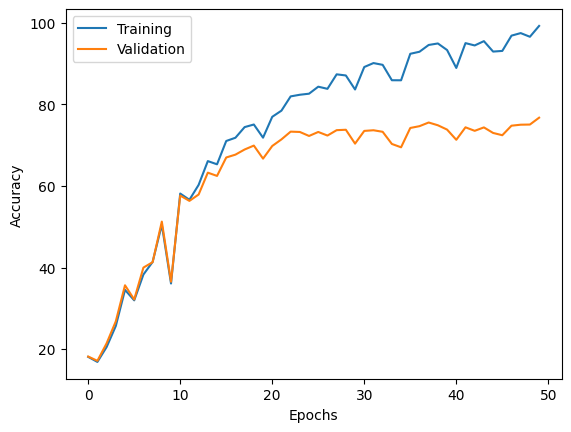

In [11]:
# Plot of train and validation accuracies
plt.plot(train_acc_list, label='Training')
plt.plot(valid_acc_list, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()